<a href="https://colab.research.google.com/github/iamtatha/POS-tagging/blob/main/Encoder-Decoder/enc_dec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import re
import keras

import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense, RepeatVector
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import LeaveOneOut,KFold

import nltk
nltk.download('treebank')
nltk.download('brown')
nltk.download('conll2000')
nltk.download('universal_tagset')
from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000
import nltk
from nltk import word_tokenize

from gensim.models import KeyedVectors

import tensorflow as tf
import tensorflow_hub as hub
from keras.utils import np_utils
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


1 Physical GPUs, 1 Logical GPUs
Version:  2.12.0
Eager mode:  True
Hub version:  0.13.0
GPU is available


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

In [ ]:
treebank_corpus = treebank.tagged_sents(tagset='universal')
brown_corpus = brown.tagged_sents(tagset='universal')
conll_corpus = conll2000.tagged_sents(tagset='universal')
tagged_sentences = treebank_corpus + brown_corpus + conll_corpus
# tagged_sentences = brown_corpus

In [ ]:
X_original = [] # store input sequence
Y_original = [] # store output sequence

X_final_test = []
Y_final_test = []

tags = set()
i = 0

for sentence in tagged_sentences:
  i += 1

  if(i % 1000 != 0):     
    X_sentence = []
    Y_sentence = []
    for entity in sentence:         
        X_sentence.append(entity[0])  # entity[0] contains the word
        Y_sentence.append(entity[1])  # entity[1] contains corresponding tag
        tags.add(entity[1]) 

    X_original.append(X_sentence)
    Y_original.append(Y_sentence)
  
  else:
    X_sentence = ""
    Y_sentence = ""
    for entity in sentence:         
        X_sentence += entity[0]
        Y_sentence += entity[1]
        X_sentence += " "
        Y_sentence += " "
         
    X_final_test.append(X_sentence)
    Y_final_test.append(Y_sentence)

In [ ]:
word_tokenizer = Tokenizer()              
word_tokenizer.fit_on_texts(X_original)   
tag_token = Tokenizer()
tag_token.fit_on_texts(Y_original)

In [ ]:
X_encoded = word_tokenizer.texts_to_sequences(X_original) 
Y_encoded = tag_token.texts_to_sequences(Y_original)

In [ ]:
EMBEDDING_SIZE  = 300  # each word in word2vec model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index

# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

In [ ]:
MAX_LENGTH=272
X = pad_sequences(X_encoded, maxlen=MAX_LENGTH, padding="post", truncating="pre")
Y = pad_sequences(Y_encoded, maxlen=MAX_LENGTH-1, padding="post", truncating="pre")

In [ ]:
del word2vec

In [ ]:
import gc
gc.collect()

0

In [ ]:
latent_dim = 300
num_encoder_tokens = 300
num_decoder_tokens = 15

In [ ]:
embedding_layer = Embedding(VOCABULARY_SIZE, EMBEDDING_SIZE, weights=[embedding_weights], input_length=MAX_LENGTH, mask_zero=True)
encoder_inputs = Input(shape=(MAX_LENGTH,))
x = embedding_layer(encoder_inputs)
encoder = LSTM(latent_dim, return_state=True)

encoder_outputs, state_h, state_c = encoder(x)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(MAX_LENGTH,))
decoder_embedding = Embedding(num_decoder_tokens, latent_dim)
decoder_inputs_x = decoder_embedding(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x,
                                    initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 272)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 272)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 272, 300)     17824500    ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 272, 300)     4500        ['input_2[0][0]']                
                                                                                              

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.20, shuffle=True)
X_final = X_train
Y_final = []

for i in range(len(y_train)):
   Y_final.append(np.array([13] + list(y_train[i])))
Y_final = np.array(Y_final)

decoder_target_data = np.zeros((len(X_train), MAX_LENGTH, num_decoder_tokens), dtype='float32')

for sentence, (input_text, target_text) in enumerate(zip(X_final, Y_final)):
  for t, tag in enumerate(target_text):
    if(t > 0):
      decoder_target_data[sentence, t-1, tag] = 1.
    
  decoder_target_data[sentence, t, 14] = 1

model.fit([X_final, Y_final], decoder_target_data,batch_size=100,epochs=100, validation_split=0.2)

Epoch 1/100
462/462 [==============================] - 83s 153ms/step - loss: 0.2057 - accuracy: 0.9374 - val_loss: 0.1710 - val_accuracy: 0.9479
Epoch 2/100
462/462 [==============================] - 40s 87ms/step - loss: 0.1630 - accuracy: 0.9493 - val_loss: 0.1596 - val_accuracy: 0.9495
Epoch 3/100
462/462 [==============================] - 41s 89ms/step - loss: 0.1550 - accuracy: 0.9510 - val_loss: 0.1487 - val_accuracy: 0.9520
Epoch 4/100
462/462 [==============================] - 37s 80ms/step - loss: 0.1485 - accuracy: 0.9522 - val_loss: 0.1441 - val_accuracy: 0.9528
Epoch 5/100
462/462 [==============================] - 36s 78ms/step - loss: 0.1455 - accuracy: 0.9531 - val_loss: 0.1423 - val_accuracy: 0.9531
Epoch 6/100
462/462 [==============================] - 38s 83ms/step - loss: 0.1429 - accuracy: 0.9537 - val_loss: 0.1404 - val_accuracy: 0.9536
Epoch 7/100
462/462 [==============================] - 39s 84ms/step - loss: 0.1408 - accuracy: 0.9543 - val_loss: 0.1479 - val_a

In [ ]:
X_testing = X_test
Y_testing = []

for i in range(len(y_test)):
  Y_testing.append(np.array([13] + list(y_test[i])))  

Y_testing = np.array(Y_testing)
decoder_data = np.zeros((len(X_testing), MAX_LENGTH, num_decoder_tokens), dtype='float32')

for sentence, (input_text, target_text) in enumerate(zip(X_testing, Y_testing)):
  for t, tag in enumerate(target_text):
    if(t < len(target_text)-1):
      decoder_data[sentence, t, tag] = 1.
    
  decoder_data[sentence, t, 13] = 1

print("Testing")
  # Testing
model.evaluate([X_testing, Y_testing], decoder_data)

Testing
451/451 [==============================] - 6s 13ms/step - loss: 0.7710 - accuracy: 0.9228


[0.770990788936615, 0.922829806804657]

In [ ]:
word2idx_inputs = word_tokenizer.word_index
word2idx_outputs = tag_token.word_index

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
# model.load_weights('encoder-decoder.h5')
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)


idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

def tag(input_seq):
    states_value = encoder_model.predict(input_seq, verbose = 0)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = 13
    eos = 14
    output_sentence = []
    for i in range(MAX_LENGTH):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose = 0)
        # print(output_tokens[0, 0, :])
        idx = np.argmax(output_tokens[0][0])
        # idx = np.argmax(output_tokens[0, -1, :])
        # print(idx, end=" ")
        # print(i)
        if eos == idx:
            break

        word = ''
      
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)
        
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = idx
        states_value = [h, c]

    x = ' '.join(output_sentence)
    return x
    # return output_sentence

# input_integer_seq = word_tokenizer.texts_to_sequences(X_original)
# encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=MAX_LENGTH, padding="post", truncating="pre")

# i = np.random.choice(len(X))
# s = encoder_input_sequences[i:i+1]
# x = tag(s)
# print(x)

Manual Test

In [ ]:
# x = ['i am not anymore the champion i used to be once and hence i will not do this kind of things anymore']
s = ['No skipping classes from tomorrow']
s = word_tokenizer.texts_to_sequences(s)
s = pad_sequences(s, maxlen=MAX_LENGTH, padding="post", truncating="pre")

# x = tag(test_samples_X)
# i = np.random.choice(len(X))
# s = encoder_input_sequences[i:i+1]
val = tag(s)
val
# input_seq

'det verb noun adp noun'

Result Analysis

In [ ]:
# word_tokenize(x)

In [ ]:
# noun noun verb verb adp det noun adp noun noun .
# det noun verb verb adp det noun .
# noun verb verb . .
# pron verb verb adp det noun adp det noun adp det noun adp det noun adp det noun adp det noun .

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import nltk
nltk.download('punkt')
mat = np.zeros((12,12))
token_list = {"noun": 1, "verb": 2, ".": 3, "adp": 4, "det": 5, "adj": 6, "adv": 7, "pron": 8, "conj": 9, "prt": 10, "num": 11, "x": 12}

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
trueLabel = []
predictedLabel = []
for i in range(len(X_final_test)):
  if i % 10  == 0:
    print(i)

  s = word_tokenizer.texts_to_sequences([X_final_test[i][:-1]])
  s = pad_sequences(s, maxlen=MAX_LENGTH, padding="post", truncating="pre")
  val = tag(s)

  # print('Predicted: ', val)
  # print('Actual: ', Y_final_test[i])

  y = word_tokenize(Y_final_test[i])
  val = word_tokenize(val)

  for i in range (len(y)):
    trueLabel.append(y[i])
    if i < len(val):
      predictedLabel.append(val[i])
    else:
      predictedLabel.append('x')

  # print(val)
  # print(y)

  for j in range(min(len(y), len(val))):
    mat[token_list[val[j].lower()] - 1][token_list[y[j].lower()] - 1] += 1

0
10
20
30
40
50
60
70


Confusion Matrix

In [ ]:
new_mat = []
for i in range(12):
  lst = []
  for j in range(12):
    lst.append(0)
  new_mat.append(lst)

for i in range(len(mat)):
  for j in range(len(mat[i])):
    new_mat[i][j] = int(mat[i][j])

# for i in range(len(mat)):
#   for j in range(len(mat[i])):
#     print(new_mat[i][j], end=" ")
#   print()

cnf_mat = pd.DataFrame(new_mat)

In [ ]:
cnf_mat

,0,1,2,3,4,5,6,7,8,9,10,11
0,171,30,21,37,43,32,5,3,7,7,4,1
1,32,105,9,15,11,13,6,15,4,9,2,0
2,6,4,1,1,2,1,2,2,0,1,0,0
3,41,15,9,75,13,11,9,5,6,4,2,0
4,22,12,8,24,60,7,4,5,4,2,1,0
5,19,8,8,15,10,29,8,1,2,0,0,0
6,3,4,7,5,0,5,25,3,2,0,0,2
7,9,9,9,9,3,0,0,26,2,0,0,0
8,12,2,6,2,1,1,1,2,12,1,1,0
9,5,11,3,4,2,1,2,3,1,13,0,0


<Axes: >

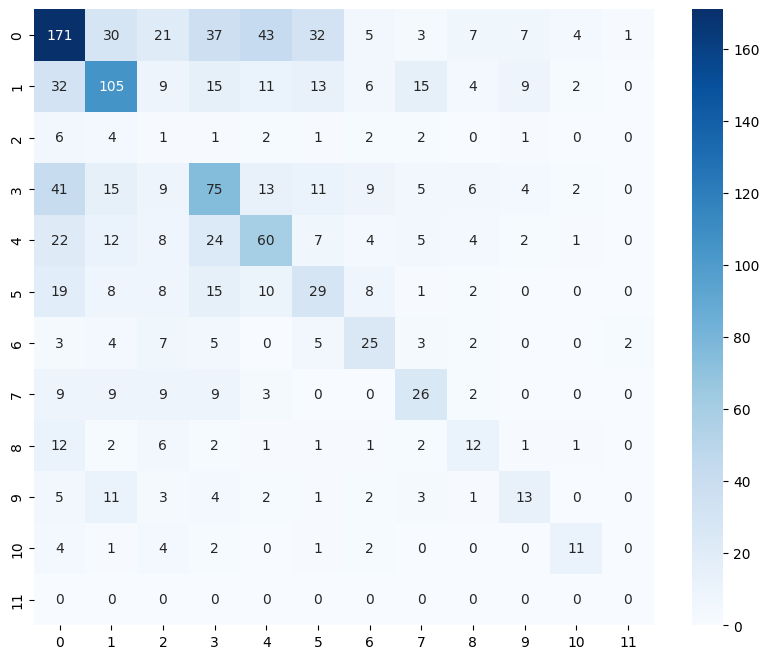

In [ ]:
import seaborn as sns
from matplotlib.pyplot import figure
figure(figsize=(10,8))
sns.heatmap(cnf_mat,annot=True,fmt='d',cmap="Blues")

Precison and Recall

In [ ]:
allTagPrecision = []
for i in range(len(new_mat)):
  truePositive = new_mat[i][i]
  sum = 0
  for j in range(len(new_mat[i])):
    sum = sum + new_mat[i][j]
  if sum == 0:
    allTagPrecision.append(0)
  else:
    allTagPrecision.append(truePositive/sum)

In [ ]:
allTagPrecision

[0.47368421052631576,
 0.4751131221719457,
 0.05,
 0.39473684210526316,
 0.40268456375838924,
 0.29,
 0.44642857142857145,
 0.3880597014925373,
 0.2926829268292683,
 0.28888888888888886,
 0.44,
 0]

In [ ]:
allTagRecall = []
for i in range(len(new_mat)):
  truePositive = new_mat[i][i]
  sum = 0
  for j in range(len(new_mat[i])):
    sum = sum + new_mat[j][i]
  if sum == 0:
    allTagRecall.append(0)
  else:
    allTagRecall.append(truePositive/sum)

In [ ]:
allTagRecall

[0.5277777777777778,
 0.5223880597014925,
 0.011764705882352941,
 0.3968253968253968,
 0.41379310344827586,
 0.2871287128712871,
 0.390625,
 0.4,
 0.3,
 0.35135135135135137,
 0.5238095238095238,
 0.0]

In [ ]:
f1_score = []
for i in range(12):
  if (allTagPrecision[i]+allTagRecall[i]) == 0:
    f1_score.append(0)
  else:
    val = (2*allTagPrecision[i]*allTagRecall[i])/(allTagPrecision[i]+allTagRecall[i])
    f1_score.append(val)

In [ ]:
f1_score

[0.4992700729927007,
 0.4976303317535545,
 0.01904761904761905,
 0.39577836411609496,
 0.40816326530612246,
 0.2885572139303482,
 0.4166666666666667,
 0.393939393939394,
 0.2962962962962963,
 0.31707317073170727,
 0.4782608695652174,
 0]

In [ ]:
tag_list = ["noun", "verb", ".", "adp", "det", "adj", "adv", "pron", "conj", "prt", "num", "x"]

In [ ]:
metricData = []
for i in range(12):
  temp = []
  temp.append(allTagPrecision[i])
  temp.append(allTagRecall[i])
  temp.append(f1_score[i])
  metricData.append(temp)

In [ ]:
metricDataFrame = pd.DataFrame(metricData)

In [ ]:
metricDataFrame.columns = ['Precison','Recall','F1-Score']
metricDataFrame.index = tag_list
metricDataFrame

,Precison,Recall,F1-Score
noun,0.473684,0.527778,0.499270
verb,0.475113,0.522388,0.497630
.,0.050000,0.011765,0.019048
adp,0.394737,0.396825,0.395778
det,0.402685,0.413793,0.408163
adj,0.290000,0.287129,0.288557
adv,0.446429,0.390625,0.416667
pron,0.388060,0.400000,0.393939
conj,0.292683,0.300000,0.296296
prt,0.288889,0.351351,0.317073


In [ ]:
word_tokenize(Y_final_test[0][:-1])

In [ ]:
l = np.zeros((5,6))
l[1,2] = 3

In [ ]:
l

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 3., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])